In [ ]:
import os
import zipfile
import numpy as np
import cv2
import tensorflow as tf
from google.colab import drive
from PIL import Image
from tensorflow.keras import layers, models, regularizers, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

DRIVE_BASE_PATH = '/content/drive/MyDrive/Görüntü_İşleme_Proje'
ZIP_FILE = os.path.join(DRIVE_BASE_PATH, 'archive.zip')
EXTRACT_PATH = '/content/dataset'
MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, 'Modeller/en_iyi_vessel_model.keras')

if not os.path.exists(os.path.join(DRIVE_BASE_PATH, 'Modeller')):
    os.makedirs(os.path.join(DRIVE_BASE_PATH, 'Modeller'))

if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def preprocess_vessel(img_path, is_mask=False):
    if is_mask:
        img = np.array(Image.open(img_path))
        img = (img > 0).astype(np.float32)
    else:
        img = cv2.imread(img_path)
        img = img[:,:,1]
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        img = img / 255.0
    return img

def get_patches(img, mask, patch_size=64, stride=32):
    img_patches, mask_patches = [], []
    h, w = img.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            img_patches.append(img[i:i+patch_size, j:j+patch_size])
            mask_patches.append(mask[i:i+patch_size, j:j+patch_size])
    return img_patches, mask_patches

train_img_dir = os.path.join(EXTRACT_PATH, 'DRIVE/training/images')
train_mask_dir = os.path.join(EXTRACT_PATH, 'DRIVE/training/1st_manual')

X_all, Y_all = [], []
img_files = sorted([f for f in os.listdir(train_img_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(train_mask_dir) if f.endswith('.gif') or f.endswith('.png')])

for img_f, mask_f in zip(img_files, mask_files):
    img = preprocess_vessel(os.path.join(train_img_dir, img_f), is_mask=False)
    mask = preprocess_vessel(os.path.join(train_mask_dir, mask_f), is_mask=True)
    p_img, p_mask = get_patches(img, mask)
    X_all.extend(p_img)
    Y_all.extend(p_mask)

X_all = np.expand_dims(np.array(X_all), axis=-1)
Y_all = np.expand_dims(np.array(Y_all), axis=-1)

X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.15, random_state=42)

data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

def train_gen_flow(img_gen, mask_gen):
    while True:
        yield next(img_gen), next(mask_gen)

train_generator = train_gen_flow(
    image_datagen.flow(X_train, batch_size=32, seed=seed),
    mask_datagen.flow(Y_train, batch_size=32, seed=seed)
)

def build_advanced_unet(input_shape=(64, 64, 1)):
    inputs = layers.Input(input_shape)
    l2_val = 1e-5

    c1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_val))(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)
    p1 = layers.SpatialDropout2D(0.1)(p1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_val))(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    p2 = layers.SpatialDropout2D(0.2)(p2)

    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)

    u1 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)
    return models.Model(inputs, outputs)

class SmartBestModelSave(tf.keras.callbacks.Callback):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.best_val_dice = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        current_val_dice = logs.get('val_dice_coefficient')
        if current_val_dice > self.best_dice_val:
            self.best_dice_val = current_val_dice
            self.model.save(self.path)
            print(f"\nModel saved: {self.best_dice_val:.4f}")

    @property
    def best_dice_val(self):
        return self.best_val_dice

    @best_dice_val.setter
    def best_dice_val(self, value):
        self.best_val_dice = value

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coefficient', patience=15, mode='max', restore_best_weights=True)

model = build_advanced_unet()
model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', dice_coefficient])

model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, Y_val),
    epochs=100,
    callbacks=[SmartBestModelSave(MODEL_SAVE_PATH), early_stop]
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8002 - dice_coefficient: 0.5566 - loss: 0.4438
Model saved: 0.0001
144/144 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.8007 - dice_coefficient: 0.5573 - loss: 0.4431 - val_accuracy: 0.9039 - val_dice_coefficient: 1.2702e-04 - val_loss: 1.0003
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9020 - dice_coefficient: 0.7347 - loss: 0.2664 - val_accuracy: 0.9038 - val_dice_coefficient: 9.9799e-05 - val_loss: 1.0004
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9030 - dice_coefficient: 0.7488 - loss: 0.2519
Model saved: 0.2831
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9030 - dice_coefficient: 0.7488 - loss: 0.2519 - val_accuracy: 0.9197 - val_dice_coefficient: 0.2831 - val_loss: 0.7147
Epoch 4/100
143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/st

Mounted at /content/drive
Model başarıyla yüklendi. Tahmin döngüsü başlıyor...

--- Analiz için resim seçin (Durdurmak için hücre yanındaki kareye basın) ---


Saving 6.jpeg to 6.jpeg


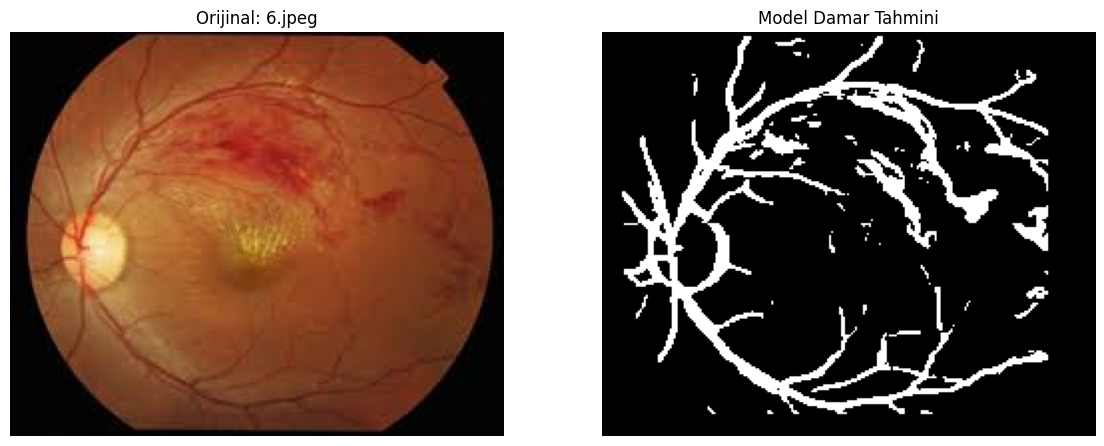

Sonuç kaydedildi: /content/drive/MyDrive/Görüntü_İşleme_Proje/Tahminler/sonuc_6.jpeg

--- Analiz için resim seçin (Durdurmak için hücre yanındaki kareye basın) ---


Saving görsel_2025-12-23_012420523.png to görsel_2025-12-23_012420523.png


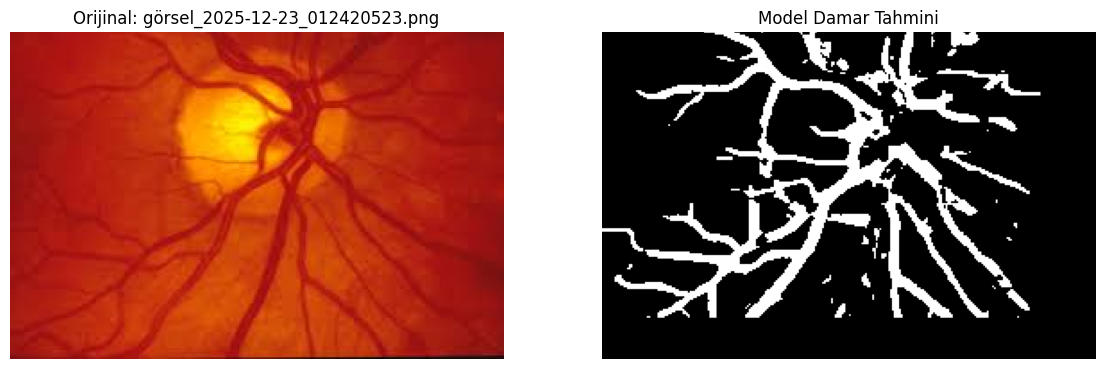

Sonuç kaydedildi: /content/drive/MyDrive/Görüntü_İşleme_Proje/Tahminler/sonuc_görsel_2025-12-23_012420523.png

--- Analiz için resim seçin (Durdurmak için hücre yanındaki kareye basın) ---


Dosya seçilmedi, döngü sonlanıyor.


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from PIL import Image

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DRIVE_BASE_PATH = '/content/drive/MyDrive/Görüntü_İşleme_Proje'
MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, 'Modeller/en_iyi_vessel_model.keras')

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def preprocess_vessel(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = img[:,:,1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    return img / 255.0

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"HATA: Model dosyası bulunamadı! Lütfen yolu kontrol edin: {MODEL_SAVE_PATH}")
else:
    test_model = load_model(MODEL_SAVE_PATH, custom_objects={
        'dice_coefficient': dice_coefficient,
        'dice_loss': dice_loss
    })
    print("Model başarıyla yüklendi. Tahmin döngüsü başlıyor...")

    try:
        while True:
            print("\n--- Analiz için resim seçin (Durdurmak için hücre yanındaki kareye basın) ---")
            uploaded = files.upload()

            if not uploaded:
                print("Dosya seçilmedi, döngü sonlanıyor.")
                break

            for filename in uploaded.keys():
                input_path = os.path.join('/content', filename)
                img_data = preprocess_vessel(input_path)

                if img_data is None:
                    print(f"Hata: {filename} okunamadı.")
                    continue

                h, w = img_data.shape
                patch_size, stride = 64, 32
                full_prediction = np.zeros((h, w), dtype=np.float32)
                count_matrix = np.zeros((h, w), dtype=np.float32)

                for i in range(0, h - patch_size + 1, stride):
                    for j in range(0, w - patch_size + 1, stride):
                        patch = img_data[i:i+patch_size, j:j+patch_size]
                        patch_input = np.expand_dims(np.expand_dims(patch, axis=0), axis=-1)
                        pred = test_model.predict(patch_input, verbose=0)[0, :, :, 0]
                        full_prediction[i:i+patch_size, j:j+patch_size] += pred
                        count_matrix[i:i+patch_size, j:j+patch_size] += 1.0

                full_prediction /= (count_matrix + 1e-7)

                raw_img = cv2.imread(input_path)
                raw_img_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(14, 7))
                plt.subplot(1, 2, 1)
                plt.title(f"Orijinal: {filename}")
                plt.imshow(raw_img_rgb)
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title("Model Damar Tahmini")
                plt.imshow(full_prediction > 0.5, cmap='gray')
                plt.axis('off')
                plt.show()

                save_dir = os.path.join(DRIVE_BASE_PATH, 'Tahminler')
                if not os.path.exists(save_dir): os.makedirs(save_dir)
                cv2.imwrite(os.path.join(save_dir, f"sonuc_{filename}"), (full_prediction > 0.5) * 255)
                print(f"Sonuç kaydedildi: {save_dir}/sonuc_{filename}")

    except KeyboardInterrupt:
        print("\nİşlem kullanıcı tarafından durduruldu.")